In [1]:
#Importing all the libraries.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
# Load the CSV file to a Pandas Dataframe

df=pd.read_csv("movie_metadata.csv")


In [3]:
#Max length of the dataframe

len(df)


5043

In [4]:
#Display the columns. Total 28 Columns.

df.columns


Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')

In [5]:
#column counts substracting from total length. If different, means missing data.

len(df)- df.count()

#So no missing data for genres, movie_title, num_voted_users, cast_total_facebook_likes, movie_imdb_link,
#imdb_score, movie_facebook_likes

color                         19
director_name                104
num_critic_for_reviews        50
duration                      15
director_facebook_likes      104
actor_3_facebook_likes        23
actor_2_name                  13
actor_1_facebook_likes         7
gross                        884
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  23
facenumber_in_poster          13
plot_keywords                153
movie_imdb_link                0
num_user_for_reviews          21
language                      12
country                        5
content_rating               303
budget                       492
title_year                   108
actor_2_facebook_likes        13
imdb_score                     0
aspect_ratio                 329
movie_facebook_likes           0
dtype: int64

In [6]:
#Applying Describe method to understand all statistical values for all the numeric fields.

df['imdb_score'].describe()

#imdb_score has max value of 9.5 and minimum value of 1.6 out of 10 for all the movies in the dataframe with a 
#mean of 6.44 having standard deviation of 1.125.

count    5043.000000
mean        6.442138
std         1.125116
min         1.600000
25%         5.800000
50%         6.600000
75%         7.200000
max         9.500000
Name: imdb_score, dtype: float64

In [7]:
#Applying Describe method to understand all statistical values for all the numeric fields.

df.describe()



,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,4993.000000,5028.000000,4939.000000,5020.000000,5036.000000,4.159000e+03,5.043000e+03,5043.000000,5030.000000,5022.000000,4.551000e+03,4935.000000,5030.000000,5043.000000,4714.000000,5043.000000
mean,140.194272,107.201074,686.509212,645.009761,6560.047061,4.846841e+07,8.366816e+04,9699.063851,1.371173,272.770808,3.975262e+07,2002.470517,1651.754473,6.442138,2.220403,7525.964505
std,121.601675,25.197441,2813.328607,1665.041728,15020.759120,6.845299e+07,1.384853e+05,18163.799124,2.013576,377.982886,2.061149e+08,12.474599,4042.438863,1.125116,1.385113,19320.445110
min,1.000000,7.000000,0.000000,0.000000,0.000000,1.620000e+02,5.000000e+00,0.000000,0.000000,1.000000,2.180000e+02,1916.000000,0.000000,1.600000,1.180000,0.000000
25%,50.000000,93.000000,7.000000,133.000000,614.000000,5.340988e+06,8.593500e+03,1411.000000,0.000000,65.000000,6.000000e+06,1999.000000,281.000000,5.800000,1.850000,0.000000
50%,110.000000,103.000000,49.000000,371.500000,988.000000,2.551750e+07,3.435900e+04,3090.000000,1.000000,156.000000,2.000000e+07,2005.000000,595.000000,6.600000,2.350000,166.000000
75%,195.000000,118.000000,194.500000,636.000000,11000.000000,6.230944e+07,9.630900e+04,13756.500000,2.000000,326.000000,4.500000e+07,2011.000000,918.000000,7.200000,2.350000,3000.000000
max,813.000000,511.000000,23000.000000,23000.000000,640000.000000,7.605058e+08,1.689764e+06,656730.000000,43.000000,5060.000000,1.221550e+10,2016.000000,137000.000000,9.500000,16.000000,349000.000000


In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
color                        5024 non-null object
director_name                4939 non-null object
num_critic_for_reviews       4993 non-null float64
duration                     5028 non-null float64
director_facebook_likes      4939 non-null float64
actor_3_facebook_likes       5020 non-null float64
actor_2_name                 5030 non-null object
actor_1_facebook_likes       5036 non-null float64
gross                        4159 non-null float64
genres                       5043 non-null object
actor_1_name                 5036 non-null object
movie_title                  5043 non-null object
num_voted_users              5043 non-null int64
cast_total_facebook_likes    5043 non-null int64
actor_3_name                 5020 non-null object
facenumber_in_poster         5030 non-null float64
plot_keywords                4890 non-null object
movie_imdb_link              5043 non-

(array([   2.,    3.,    2.,    6.,    3.,    4.,    8.,    9.,    9.,
           8.,   24.,   12.,   29.,   23.,   14.,   44.,   20.,   56.,
          71.,   31.,  104.,   42.,  139.,   92.,  202.,  229.,  124.,
         275.,  179.,  351.,  185.,  387.,  404.,  174.,  365.,  195.,
         331.,  264.,  114.,  181.,   75.,  111.,   40.,   53.,   28.,
           7.,    8.,    3.,    2.,    1.]),
 array([ 1.6  ,  1.758,  1.916,  2.074,  2.232,  2.39 ,  2.548,  2.706,
         2.864,  3.022,  3.18 ,  3.338,  3.496,  3.654,  3.812,  3.97 ,
         4.128,  4.286,  4.444,  4.602,  4.76 ,  4.918,  5.076,  5.234,
         5.392,  5.55 ,  5.708,  5.866,  6.024,  6.182,  6.34 ,  6.498,
         6.656,  6.814,  6.972,  7.13 ,  7.288,  7.446,  7.604,  7.762,
         7.92 ,  8.078,  8.236,  8.394,  8.552,  8.71 ,  8.868,  9.026,
         9.184,  9.342,  9.5  ]),
 <a list of 50 Patch objects>)

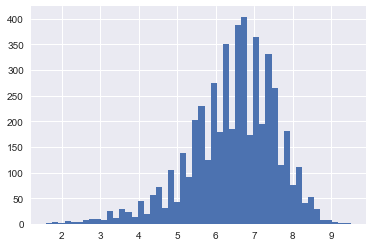

In [61]:
#Histogram of IMDB Movie Score

plt.hist(df.imdb_score.dropna(),bins=50)

#df['imdb_score'].plot(kind='hist', title='HISTOGRAM OF IMDB MOVIE SCORE(1-10)',bins=150)


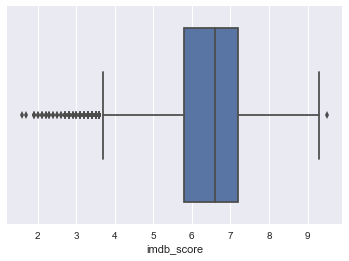

In [68]:
#boxplot of IMDB_SCORE
sns.boxplot(df.imdb_score.dropna())

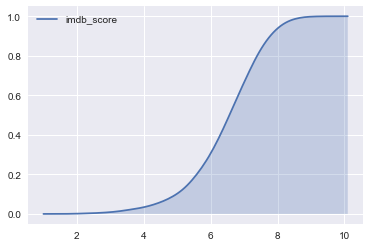

In [78]:
#Kernel Density Estimate Plot for IMDB_SCORE
sns.kdeplot(df.imdb_score,shade=True,cumulative=True)

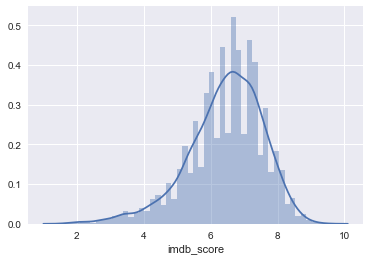

In [73]:
sns.distplot(df.imdb_score)

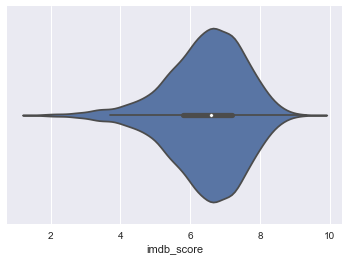

In [77]:
#violinplot

sns.violinplot(df.imdb_score)

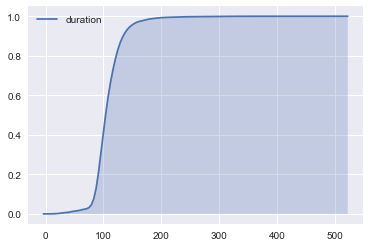

In [84]:
#KDE of duration

sns.kdeplot(df.duration.dropna(),cumulative=True,shade=True)


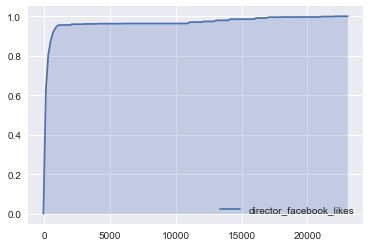

In [86]:
#KDE OF director_facebook_likes

sns.kdeplot(df.director_facebook_likes.dropna(),cumulative=True,shade=True)

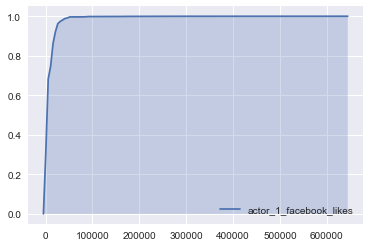

In [88]:
#KDE OF actor_1_facebook_likes

sns.kdeplot(df.actor_1_facebook_likes.dropna(),cumulative=True,shade=True)

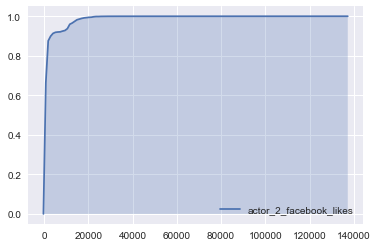

In [90]:
#KDE OF actor_2_facebook_likes

sns.kdeplot(df.actor_2_facebook_likes.dropna(),cumulative=True,shade=True)

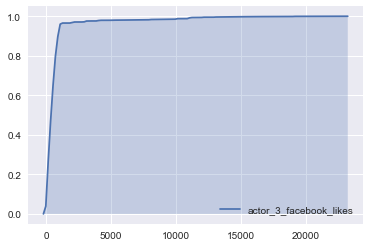

In [92]:
#KDE OF actor_3_facebook_likes

sns.kdeplot(df.actor_3_facebook_likes.dropna(),cumulative=True,shade=True)

C:\Users\Amrita\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


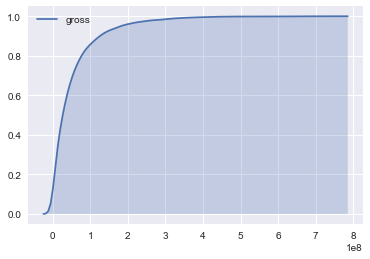

In [95]:
#KDE OF gross VS Budget

sns.kdeplot(df.gross.dropna(),cumulative=True,shade=True)
#sns.kdeplot(df.budget.dropna(),cumulative=True,shade=True)

In [10]:
# IMDB SCORE will be my pridected output variable. Float Variable.

# Check to see if imdb_score field is having any missing values or not.

df[df['imdb_score'] < 1]

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes


In [11]:
df[df['imdb_score'] < 0]

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes


In [12]:
len(df[df['imdb_score'].notnull()])

5043

In [13]:
len(df[df['imdb_score'].isnull()])


0

In [14]:
len(df)- df.count()

color                         19
director_name                104
num_critic_for_reviews        50
duration                      15
director_facebook_likes      104
actor_3_facebook_likes        23
actor_2_name                  13
actor_1_facebook_likes         7
gross                        884
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  23
facenumber_in_poster          13
plot_keywords                153
movie_imdb_link                0
num_user_for_reviews          21
language                      12
country                        5
content_rating               303
budget                       492
title_year                   108
actor_2_facebook_likes        13
imdb_score                     0
aspect_ratio                 329
movie_facebook_likes           0
dtype: int64

In [15]:
# Define Function which will determine missing value percentages for any Data Fields

def missval_chk(data):
    missval_cnt = len(df)- df.count()
    isnull_count = len(df[df[data].isnull()])
    if len(df)> 0:
        percent = ((missval_cnt[data]/len(df)) * 100)
    else:
        percent = 0.0
    return isnull_count, percent

def function(*args):
    for arg in args:
        print("Missing value count,percent for " + arg + " col: " + str(missval_chk(arg)))
       

In [16]:
function('duration','actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes',
             'director_facebook_likes','imdb_score')

Missing value count,percent for duration col: (15, 0.29744199881023198)
Missing value count,percent for actor_1_facebook_likes col: (7, 0.13880626611144162)
Missing value count,percent for actor_2_facebook_likes col: (13, 0.25778306563553438)
Missing value count,percent for actor_3_facebook_likes col: (23, 0.45607773150902242)
Missing value count,percent for director_facebook_likes col: (104, 2.062264525084275)
Missing value count,percent for imdb_score col: (0, 0.0)


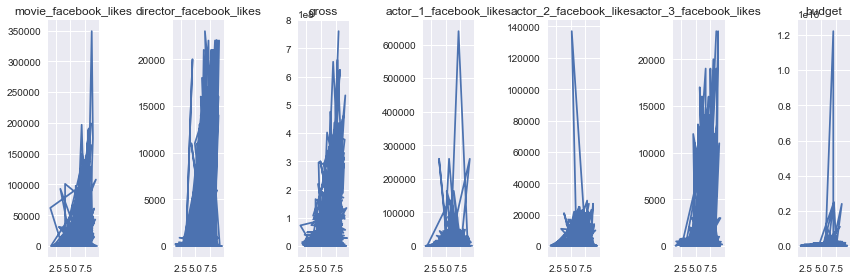

In [17]:

fig, axes = plt.subplots(1, 7, figsize=(12, 4))

axes[0].plot(df['imdb_score'], df['movie_facebook_likes'])
axes[0].set_title("movie_facebook_likes")

axes[1].plot(df['imdb_score'], df['director_facebook_likes'])
axes[1].axis('tight')
axes[1].set_title("director_facebook_likes")

axes[2].plot(df['imdb_score'], df['gross'])
axes[2].set_title("gross")

axes[3].plot(df['imdb_score'], df['actor_1_facebook_likes'])
axes[3].set_title("actor_1_facebook_likes")

axes[4].plot(df['imdb_score'], df['actor_2_facebook_likes'])
axes[4].axis('tight')
axes[4].set_title("actor_2_facebook_likes")

axes[5].plot(df['imdb_score'], df['actor_3_facebook_likes'])
axes[5].set_title("actor_3_facebook_likes")

axes[6].plot(df['imdb_score'], df['budget'])
axes[6].set_title("budget")

plt.tight_layout()

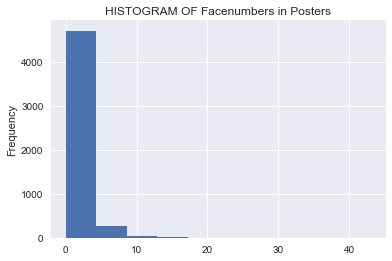

In [18]:
#Histogram of facenumber_in_poster

df['facenumber_in_poster'].plot(kind='hist', title='HISTOGRAM OF Facenumbers in Posters')

#nearly 95% of all the 4096 posters have less than 5 faces.

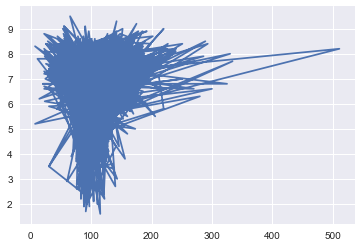

In [19]:
plt.plot(df['duration'], df['imdb_score'])

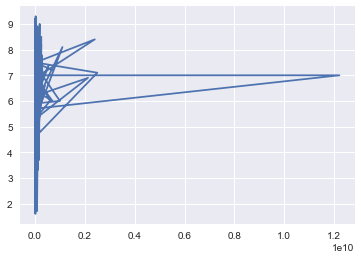

In [20]:
plt.plot(df['budget'], df['imdb_score'] )

# check % of total # of rows we'll have to drop across all 4 cols

In [21]:
# My output column is imdb_score.
# No missing values for imdb_score, so no rows dropping for this. Total rows are 5043.

In [22]:
#My three choosen input columns are
#director_facebook_likes(104 rows)
#actor_1/2/3_facebook_likes(Total 43 rows)
#duration(15 rows)

In [23]:
#Dataframe copied to a new one for dropping/manipulation purpose.
df_copy= df.copy()

In [24]:
# Writing a function which will determine % of rows dropped for these input and output variables selected.

def droprows_det(arg1,arg2,arg3,arg4,arg5,arg6):
    
        counter=len(df_copy) 
        print("Total Number of rows for the dataframe: " + str(counter))
        #print("Missing value count,percent for duration col: " + str(missval_chk('duration'))
    
        df_copy1= df_copy[df_copy[arg1].notnull()]  
        percent1= ((counter - len(df_copy1))/ counter)*100
        counter1=len(df_copy1) 
        print("% of rows(" + str(counter-counter1)+ ") dropped for " + arg1 + " column " + " is : " + str(percent1))
        print("New dataframe size is: "  + str(counter1))
        
        df_copy2= df_copy1[df_copy1[arg2].notnull()]
        percent2= ((counter1 - len(df_copy2))/ counter1)*100
        counter2=len(df_copy2)
        print("% of rows(" + str(counter1-counter2)+ ") dropped for " + arg2 + " column " + " is : " + str(percent2))
        print("New dataframe size is: "  + str(counter2))
        
                
        df_copy3= df_copy2[df_copy2[arg3].notnull()] 
        percent3= ((counter2 - len(df_copy3))/ counter2)*100
        counter3=len(df_copy3)
        print("% of rows(" + str(counter2-counter3)+ ") dropped for " + arg3 + " column " + " is : " + str(percent3))
        print("New dataframe size is: "  + str(counter3))
                
        df_copy4= df_copy3[df_copy3[arg4].notnull()] 
        percent4= ((counter3 - len(df_copy4))/ counter3)*100
        counter4=len(df_copy4)
        print("% of rows(" + str(counter3-counter4)+ ") dropped for " + arg4 + " column " + " is : " + str(percent4))
        print("New dataframe size is: "  + str(counter4))
                
        df_copy5= df_copy4[df_copy4[arg5].notnull()] 
        percent5= ((counter4 - len(df_copy5))/ counter4)*100
        counter5=len(df_copy5)
        print("% of rows(" + str(counter4-counter5)+ ") dropped for " + arg5 + " column " + " is : " + str(percent5))
        print("New dataframe size is: "  + str(counter5))
        
        df_copy6= df_copy5[df_copy5[arg6].notnull()] 
        percent6= ((counter5 - len(df_copy5))/ counter5)*100
        counter6=len(df_copy6)
        print("% of rows(" + str(counter5-counter6)+ ") dropped for " + arg6 + " column " + " is : " + str(percent6))
        print("New dataframe size is: "  + str(counter6))
        

In [25]:
droprows_det('duration','actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes',
             'director_facebook_likes','imdb_score')

Total Number of rows for the dataframe: 5043
% of rows(15) dropped for duration column  is : 0.297441998810232
New dataframe size is: 5028
% of rows(7) dropped for actor_1_facebook_likes column  is : 0.13922036595067622
New dataframe size is: 5021
% of rows(6) dropped for actor_2_facebook_likes column  is : 0.11949810794662419
New dataframe size is: 5015
% of rows(8) dropped for actor_3_facebook_likes column  is : 0.15952143569292124
New dataframe size is: 5007
% of rows(99) dropped for director_facebook_likes column  is : 1.9772318753744758
New dataframe size is: 4908
% of rows(0) dropped for imdb_score column  is : 0.0
New dataframe size is: 4908


In [26]:
print(len(df_copy))
df_copy= df_copy[df_copy['duration'].notnull()] 
print(len(df_copy))
df_copy=df_copy[df_copy['actor_1_facebook_likes'].notnull()] 
print(len(df_copy))
df_copy=df_copy[df_copy['actor_2_facebook_likes'].notnull()] 
print(len(df_copy))
df_copy=df_copy[df_copy['actor_3_facebook_likes'].notnull()] 
print(len(df_copy))
df_copy=df_copy[df_copy['director_facebook_likes'].notnull()] 
print(len(df_copy))
df_copy=df_copy[df_copy['imdb_score'].notnull()] 
print(len(df_copy))

5043
5028
5021
5015
5007
4908
4908


In [27]:
(df_copy)
        

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
5,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,...,738.0,English,USA,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000
6,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,Action|Adventure|Romance,...,1902.0,English,USA,PG-13,258000000.0,2007.0,11000.0,6.2,2.35,0
7,Color,Nathan Greno,324.0,100.0,15.0,284.0,Donna Murphy,799.0,200807262.0,Adventure|Animation|Comedy|Family|Fantasy|Musi...,...,387.0,English,USA,PG,260000000.0,2010.0,553.0,7.8,1.85,29000
8,Color,Joss Whedon,635.0,141.0,0.0,19000.0,Robert Downey Jr.,26000.0,458991599.0,Action|Adventure|Sci-Fi,...,1117.0,English,USA,PG-13,250000000.0,2015.0,21000.0,7.5,2.35,118000
9,Color,David Yates,375.0,153.0,282.0,10000.0,Daniel Radcliffe,25000.0,301956980.0,Adventure|Family|Fantasy|Mystery,...,973.0,English,UK,PG,250000000.0,2009.0,11000.0,7.5,2.35,10000
10,Color,Zack Snyder,673.0,183.0,0.0,2000.0,Lauren Cohan,15000.0,330249062.0,Action|Adventure|Sci-Fi,...,3018.0,English,USA,PG-13,250000000.0,2016.0,4000.0,6.9,2.35,197000


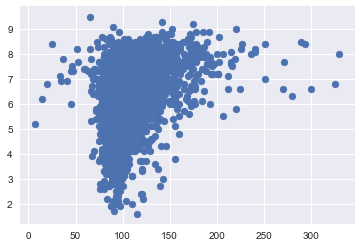

In [28]:
plt.scatter(df_copy['duration'], df_copy['imdb_score'] )

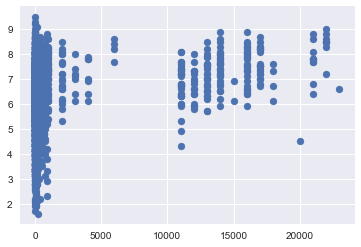

In [29]:
plt.scatter(df_copy['director_facebook_likes'], df_copy['imdb_score'] )

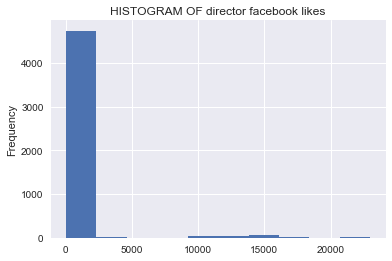

In [30]:
df['director_facebook_likes'].plot(kind='hist', title='HISTOGRAM OF director facebook likes')

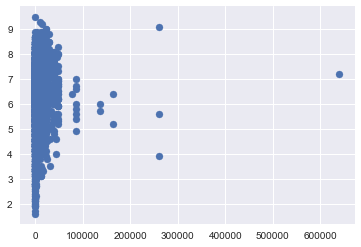

In [31]:
plt.scatter(df_copy['actor_1_facebook_likes'], df_copy['imdb_score'] )

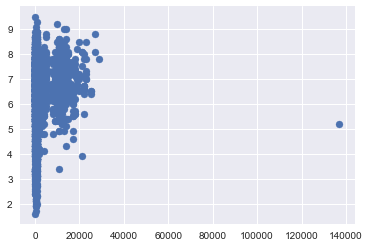

In [32]:
plt.scatter(df_copy['actor_2_facebook_likes'], df_copy['imdb_score'] )


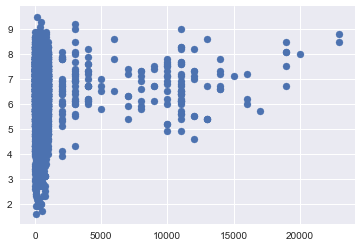

In [33]:
plt.scatter(df_copy['actor_3_facebook_likes'], df_copy['imdb_score'] )

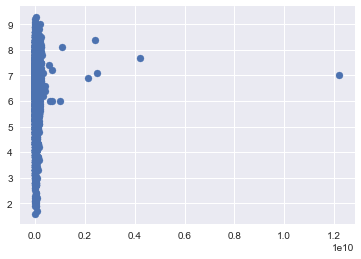

In [34]:
plt.scatter(df_copy['budget'], df_copy['imdb_score'] )

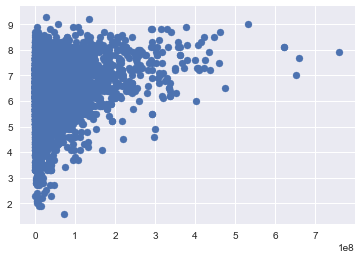

In [35]:
plt.scatter(df_copy['gross'], df_copy['imdb_score'] )

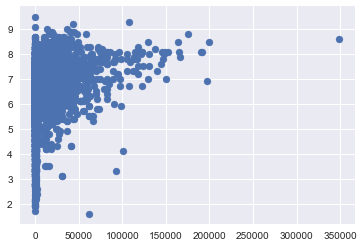

In [36]:
plt.scatter(df_copy['movie_facebook_likes'], df_copy['imdb_score'] )